In [1]:
import numpy as np
import math
import pandas as pd
import matplotlib.pyplot as plt


from scipy.optimize import fsolve, curve_fit
from scipy import integrate


h_eV = 4.1356676E-15 #Plancks constant in eV*s

hk_eV = 6.582119569E-16 #Plancks constant / 2pi in eV*s

kB_eV = 8.61733E-5 #Boltzmann constant in eV/K

kB_J = 1.38064852E-23 #Boltzmann constant in J/K

e_C = 1.602176634E-19 #electron charge in Coulomb

In [2]:
class Point_SKB:
    def __init__(self, tot_carr_conc, T, Eg300, Eac, eff_mass_elec, eff_mass_hole, density, sound_speed, kl300, kl_exp, Eg_lin):
        
        self.tot_carr_conc = tot_carr_conc
        self.T = T
        self.Eg = Eg300-(Eg_lin/100000)*T
        self.alpha = (kB_eV * T / self.Eg)
        
        self.density = density #kg/m3
        self.sound_speed = sound_speed #m/s
        self.Eac = Eac
        
        self.eff_mass_elec = eff_mass_elec
        self.eff_mass_hole = eff_mass_hole
        
        self.kl300 = kl300
        self.kl_exp = kl_exp
        
        
        
    @staticmethod
    def fermi_int_SKB(red_chem_pot, alpha, n, m, k):
        
        fermi_derivative = lambda epsilon: math.exp(epsilon - red_chem_pot) / ((1+math.exp(epsilon - red_chem_pot))**2)
        
        other_terms = lambda epsilon: (epsilon**n) * ((epsilon + alpha*(epsilon**2))**m) * ((1 + 2*alpha*epsilon)**k)
        
        together  = lambda epsilon: fermi_derivative(epsilon) * other_terms(epsilon)
        
        return float(integrate.quad(together, 0, 80)[0])
    
    @staticmethod
    def Seebeck_SKB(red_chem_pot, alpha):
        """
        returns Seebeck coefficient in V/K
        """
        
        integrals = Point_SKB.fermi_int_SKB(red_chem_pot, alpha, 1, 1, -2) / Point_SKB.fermi_int_SKB(red_chem_pot, alpha, 0, 1, -2)
        
        return (kB_J / e_C) * (integrals - red_chem_pot)
    
    @staticmethod
    def carrier_conc_SKB(red_chem_pot, alpha, eff_mass, T):
        """
        returns carrier concentration in 1/(m**3)
        """
        
        nominator = (2 * eff_mass * (9.10938356E-31) * kB_eV * T)**(3/2)
        
        denominator = 3 * (math.pi**3) * (hk_eV**3)
        
        integral = Point_SKB.fermi_int_SKB(red_chem_pot, alpha, 0, (3/2), 0)
        
        return (nominator/denominator) * integral * ((6.2415E18)**(3/2)) / (1.0E6)
    
    @staticmethod
    def sigma_SKB(red_chem_pot, alpha, eff_mass, density, sound_speed, Eac):
        
        constants1 = (e_C**2)/(eff_mass * (9.10938356E-31))
        
        constants2 = (2*hk_eV*density*(sound_speed**2)) / (3 * math.pi * (Eac**2))
        
        integral = Point_SKB.fermi_int_SKB(red_chem_pot, alpha, 0, 1, -2)
        
        return constants1 * constants2 * integral * ((1.60217662E-19)**(-1))
    
    @staticmethod
    def bipolar_therm_cond_SKB(T, Seeb_list, sig_list):
        """
        returns bipolar thermal conductivity in W/m/K if:
        T in Kelvin
        Seebeck in V/K
        sigma in S/m
        """
        
        if len(Seeb_list)!= 3 or len(sig_list)!=3 :
            print("Seeb_list and sig_lis have different lengths not equal to 3")
            
        f = lambda Seeb, sig: sig * (Seeb**2)
        
        res = f(Seeb_list[0], sig_list[0]) + f(Seeb_list[1], sig_list[1]) - f(Seeb_list[2], sig_list[2])
            
        return res * T
    
    
    @staticmethod
    def Lorenz_SKB(red_chem_pot, alpha):
        
        integrals1 = Point_SKB.fermi_int_SKB(red_chem_pot, alpha, 2, 1, -2) / Point_SKB.fermi_int_SKB(red_chem_pot, alpha, 0, 1, -2)
        
        integrals2 = Point_SKB.fermi_int_SKB(red_chem_pot, alpha, 1, 1, -2) / Point_SKB.fermi_int_SKB(red_chem_pot, alpha, 0, 1, -2)
        
        return ((kB_J/e_C)**2) * (integrals1 - (integrals2**2))
    
    @staticmethod
    def kappa_lat(T, kl300, kl_exp):
        return (kl300 * (T/300)**kl_exp)
    
    def calculate_carrier_concentrations(self, verbose = False):
        """
        Warning CHANGED HERE 
        """
        #old version
        #f = lambda red_chem_pot: self.tot_carr_conc - \
        #                        self.carrier_conc_SKB(red_chem_pot, self.alpha, self.eff_mass_elec, self.T) + \
        #                        self.carrier_conc_SKB((-red_chem_pot - self.Eg), self.alpha, self.eff_mass_hole ,self.T)
        #new version
        
        f = lambda red_chem_pot: self.tot_carr_conc - \
                                self.carrier_conc_SKB(red_chem_pot, self.alpha, self.eff_mass_elec, self.T) + \
                                self.carrier_conc_SKB((-red_chem_pot - self.Eg/(kB_eV*self.T)), self.alpha, self.eff_mass_hole ,self.T)
        
        self.red_chem_pot = fsolve(f, 0.001)[0]
        
        #change here!!!
        self.red_chem_pot_min = -self.red_chem_pot - (self.Eg/(kB_eV*self.T))
        
        self.elec_conc = self.carrier_conc_SKB(self.red_chem_pot, self.alpha, self.eff_mass_elec, self.T) #/ self.r_factor(self.red_chem_pot)
        self.hole_conc = self.carrier_conc_SKB((self.red_chem_pot_min), self.alpha, self.eff_mass_hole ,self.T) #/ self.r_factor(self.red_chem_pot_min)
        self.carrier_tolerance = (self.elec_conc-self.hole_conc-self.tot_carr_conc) / self.tot_carr_conc
        
        if verbose:
            print("Reduced chemical potential: {}".format(self.red_chem_pot))
            print("Electron concentration: {} cm-3".format(self.elec_conc))
            print("Hole concentration: {} cm-3".format(self.hole_conc))
            print("Carrier difference: {}".format(self.carrier_tolerance))
            
    def calculate_conductivities(self, verbose = False):
        
        self.elec_conductivity = self.sigma_SKB(self.red_chem_pot, self.alpha, self.eff_mass_elec, self.density, self.sound_speed, self.Eac)
        self.hole_conductivity = self.sigma_SKB((self.red_chem_pot_min), self.alpha, self.eff_mass_hole, self.density, self.sound_speed, self.Eac)
        self.tot_conductivity = self.elec_conductivity + self.hole_conductivity        
        
        if verbose:
            print("Electron conductivity: {} S/m".format(self.elec_conductivity))
            print("Hole conductivity: {} S/m".format(self.hole_conductivity))
            print("Total conductivity: {} S/m".format(self.tot_conductivity))
            
    def calculate_Seebecks(self, verbose = False):
        
        self.elec_Seebeck = self.Seebeck_SKB(self.red_chem_pot, self.alpha) * (-1)
        self.hole_Seebeck = self.Seebeck_SKB((self.red_chem_pot_min), self.alpha)
        self.tot_Seebeck = ( (self.elec_conductivity * self.elec_Seebeck) + (self.hole_conductivity * self.hole_Seebeck) ) / self.tot_conductivity
        
        if verbose:
            print("Electron Seebeck: {} V/K".format(self.elec_Seebeck))
            print("Hole Seebeck: {} V/K".format(self.hole_Seebeck))
            print("Total Seebeck: {} V/K".format(self.tot_Seebeck))
            
    def calculate_bipolar_therm_cond(self, verbose = False):
        
        Seeb_list = [self.elec_Seebeck, self.hole_Seebeck, self.tot_Seebeck]
        sig_list = [self.elec_conductivity, self.hole_conductivity, self.tot_conductivity]
        
        self.bipolar_therm_cond = self.bipolar_therm_cond_SKB(self.T, Seeb_list, sig_list)
        
        if verbose:
            print("Bipolar thermal conductivity: {} W/m/K".format(self.bipolar_therm_cond))
            
    def calculate_Lorenz_numbers(self, verbose = False):
        
        self.elec_Lorenz = self.Lorenz_SKB(self.red_chem_pot, self.alpha)
        self.hole_Lorenz = self.Lorenz_SKB((self.red_chem_pot_min), self.alpha)
        
        if verbose:
            print("Electron Lorenz: {} W * Ohm * K**-2".format(self.elec_Lorenz))
            print("Hole Lorenz: {} W * Ohm * K**-2".format(self.hole_Lorenz))
            
    def calculate_carrier_therm_cond(self, verbose = False):
        
        self.elec_therm_cond = self.T * self.elec_Lorenz * self.elec_conductivity
        self.hole_therm_cond = self.T * self.hole_Lorenz * self.hole_conductivity
        self.carrier_therm_cond = self.elec_therm_cond + self.hole_therm_cond + self.bipolar_therm_cond
        
        if verbose:
            print("Electron thermal conductivity: {} W/m/K".format(self.elec_therm_cond))
            print("Hole thermal conductivity: {} W/m/K".format(self.hole_therm_cond))
            print("Carrier thermal conductivity (including bipolar): {} W/m/K".format(self.carrier_therm_cond))
            
    def calculate_kappa(self, verbose = False):
        self.latt_therm_cond = self.kappa_lat(self.T, self.kl300, self.kl_exp)
        self.total_therm_cond = self.latt_therm_cond + self.carrier_therm_cond
        if verbose:
            print("Lattice thermal conductivity: {} W/m/K".format(self.latt_therm_cond))
            print("Total thermal conductivity: {} W/m/K".format(self.total_therm_cond))
            
            
    def calculate_all(self, verbose = False):
        self.calculate_carrier_concentrations(verbose = verbose)
        self.calculate_conductivities(verbose = verbose)
        self.calculate_Seebecks(verbose = verbose)
        self.calculate_bipolar_therm_cond(verbose = verbose) 
        self.calculate_Lorenz_numbers(verbose = verbose)
        self.calculate_carrier_therm_cond(verbose = verbose)
        self.calculate_kappa(verbose = verbose)
        
    def report(self, calculate = 'All' ,what = ['Temperature','total_Seebeck', 'total_sigma', 'carrier_therm_cond']): 
        
        if calculate == 'Seeb_sig': 
            what = ['total_Seebeck', 'total_sigma']
            self.calculate_carrier_concentrations(verbose = False)
            self.calculate_conductivities(verbose = False)
            self.calculate_Seebecks(verbose = False)
        elif calculate == 'Seeb_sig_kappa':
            what = ['total_Seebeck', 'total_sigma', 'total_therm_cond']
            self.calculate_all(verbose = False)
        elif calculate == 'Thermoelectric':
            what = ['Temperature','total_Seebeck', 'total_sigma', 'carrier_therm_cond', 'total_therm_cond']
            self.calculate_all(verbose = False)
        elif calculate == 'All': 
            what = ['Temperature', 'Red_chem_pot', 'electron_conc', 'hole_conc', 'carrier_diff',
                    'electron_sigma', 'hole_sigma', 'total_sigma', 'electron_Seebeck', 'hole_Seebeck', 'total_Seebeck', 'bipolar_therm_cond',
                    'electron_therm_cond', 'hole_therm_cond', 'carrier_therm_cond', 'latt_therm_cond', 'total_therm_cond']
            self.calculate_all(verbose = False)
        else:
            self.calculate_all(verbose = False)
    
        dictionary = {'Temperature': self.T,
                      'Red_chem_pot': self.red_chem_pot,
                      'electron_conc': self.elec_conc,
                      'hole_conc': self.hole_conc,
                      'carrier_diff': self.carrier_tolerance,
                      'electron_sigma': self.elec_conductivity,
                      'hole_sigma': self.hole_conductivity,
                      'total_sigma': self.tot_conductivity, 
                      'electron_Seebeck': self.elec_Seebeck,
                      'hole_Seebeck': self.hole_Seebeck,
                      'total_Seebeck': self.tot_Seebeck,
                      'bipolar_therm_cond': self.bipolar_therm_cond,
                      #no need to check the above for existence
                      'electron_therm_cond': self.elec_therm_cond if hasattr(self, 'elec_therm_cond') else np.nan,
                      'hole_therm_cond': self.hole_therm_cond if hasattr(self, 'hole_therm_cond') else np.nan,
                      'carrier_therm_cond': self.carrier_therm_cond if hasattr(self, 'carrier_therm_cond') else np.nan,
                      'latt_therm_cond': self.latt_therm_cond if hasattr(self, 'latt_therm_cond') else np.nan,
                      'total_therm_cond': self.total_therm_cond if hasattr(self, 'total_therm_cond') else np.nan
                     }
        res = np.array([float(dictionary[x]) for x in what])
        return res
        
    
    
    
#Test functions  
    
#print(Point_SKB.fermi_int_SKB(0.3, 0.15, 0, 1, 2))  
#print(Point_SKB.Seebeck_SKB(1.0, 0.13))
#print(Point_SKB.carrier_conc_SKB(1.0, 0.13, 1.06, 300))
#print(Point_SKB.sigma_SKB(1.0, 0.13, 1.06, 7700, 1850, 22))
#print(Point_SKB.Lorenz_SKB(1.0, 0.13))

test = Point_SKB(15.0E19, 700, 0.2, 1.8, 1.06, 1.06, 7700, 1850, 1, -1.02, -9.5)
#test.calculate_carrier_concentrations(verbose = True)
#test.calculate_conductivities(verbose = True)
#test.calculate_Seebecks(verbose = True)
#test.calculate_bipolar_therm_cond(verbose = True)
#test.calculate_Lorenz_numbers(verbose = True)
#test.calculate_carrier_therm_cond(verbose = True)
#test.calculate_kappa(verbose = True)
test.calculate_all(verbose = True)
test.report()
        

Reduced chemical potential: 1.409472792267411
Electron concentration: 1.5018257280667494e+20 cm-3
Hole concentration: 1.8257280667494067e+17 cm-3
Carrier difference: 0.0
Electron conductivity: 107177.76965588109 S/m
Hole conductivity: 259.3107815876605 S/m
Total conductivity: 107437.08043746874 S/m
Electron Seebeck: -8.735364290322943e-05 V/K
Hole Seebeck: 0.0006325601836762262 V/K
Total Seebeck: -8.561605457445188e-05 V/K
Bipolar thermal conductivity: 0.09384911049182271 W/m/K
Electron Lorenz: 1.3880551516211003e-08 W * Ohm * K**-2
Hole Lorenz: 9.69747787056572e-09 W * Ohm * K**-2
Electron thermal conductivity: 1.0413805871707376 W/m/K
Hole thermal conductivity: 0.0017602623962318068 W/m/K
Carrier thermal conductivity (including bipolar): 1.136989960058792 W/m/K
Lattice thermal conductivity: 0.42137006481451633 W/m/K
Total thermal conductivity: 1.5583600248733083 W/m/K


array([ 7.00000000e+02,  1.40947279e+00,  1.50182573e+20,  1.82572807e+17,
        0.00000000e+00,  1.07177770e+05,  2.59310782e+02,  1.07437080e+05,
       -8.73536429e-05,  6.32560184e-04, -8.56160546e-05,  9.38491105e-02,
        1.04138059e+00,  1.76026240e-03,  1.13698996e+00,  4.21370065e-01,
        1.55836002e+00])

In [7]:
class Sample:
    """
    in **kwargs
    {'tot_carr_conc':, 'T':, 'Eg300':, 'Eac':, 'eff_mass_elec':, 'eff_mass_hole':, 'density':, 'sound_speed':, 'kl300':, 'kl_exp':, 'Eg_lin':}
    """
    
    def __init__(self, name, T_list, kwargs):
        self.name = name
        self.T_list = np.array(T_list)
        
        self.tot_carr_conc = kwargs.pop('tot_carr_conc')
                
        self.Eg300 = kwargs.pop('Eg300')
        
        self.Eac = kwargs.pop('Eac')
        
        self.eff_mass_hole = kwargs.pop('eff_mass_hole')
        self.eff_mass_elec = kwargs.pop('eff_mass_elec')
        
        self.density = kwargs.pop('density')
        self.sound_speed = kwargs.pop('sound_speed')
        
        self.kl300 = kwargs.pop('kl300')
        self.kl_exp = kwargs.pop('kl_exp')
        self.Eg_lin = kwargs.pop('Eg_lin')
        
        self.points = np.array([Point_SKB(self.tot_carr_conc, T, self.Eg300, self.Eac, self.eff_mass_elec, self.eff_mass_hole, self.density, self.sound_speed, self.kl300, self.kl_exp, self.Eg_lin).report(calculate = 'Seeb_sig_kappa') for T in self.T_list])
        
        self.points = self.points.T
        self.points[0] = self.points[0]*1.0E4
        self.points[1] = self.points[1]*1.0E-5
        self.points = self.points.T
        
    def calculate_all(self):
        return np.array([Point_SKB(self.tot_carr_conc, T, self.Eg300, self.Eac, self.eff_mass_elec, self.eff_mass_hole, self.density, self.sound_speed, self.kl300, self.kl_exp, self.Eg_lin).report(calculate = 'All') for T in self.T_list])


    
argument_dict_test = {'tot_carr_conc':    -2.4*1.0E19,
                     'Eg300'        :     0.2,
                     'Eac'          :     1.25,
                     'eff_mass_elec':     2.40, 
                     'eff_mass_hole':     1.0, 
                     'density'      :     7700,
                     'sound_speed'  :     1850,
                     'kl300'        :     0.5,
                     'kl_exp'       :     -0.4,
                     'Eg_lin'       :     -9.5
                    }

test = Sample("name", [300], argument_dict_test)
print(test.calculate_all())

[[ 3.00000000e+02 -1.00973314e+01  1.79002093e+15  2.40017900e+19
  -3.41333333e-16  4.44385027e+00  3.25977029e+05  3.25981472e+05
  -1.01250961e-03  1.06048250e-04  1.06033001e-04  1.66798315e-03
   1.44395560e-05  1.39224975e+00  1.39393217e+00  5.00000000e-01
   1.89393217e+00]]


     T       sigma       Seeb  kappa
0  300  1271.55944  143.43174  1.390
1  325  1166.63230  150.14895  1.360
2  350  1051.16457  156.85456  1.340
3  375   959.06549  163.57467  1.322
4  400   878.80051  168.33293  1.300
48
48


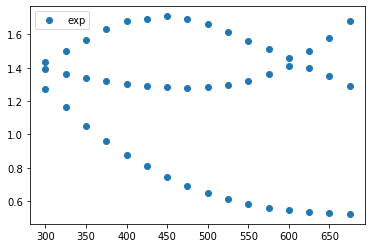

In [12]:
family = 'p_type'
#sample = 'Bi2Te2.67Se0.3Cl0.03'
sample = 'p2'

df = pd.read_excel('data_'+family+'.xlsx', sheet_name = sample)
print(df.head())
xdata = df['T'].tolist()
xdata = xdata*3
ComboX = np.array(xdata)
print(len(ComboX))

y1data = (df['Seeb']/100).tolist()
y2data = (df['sigma']/1000).tolist()
y3data = df['kappa'].tolist()
ydata = y1data + y2data + y3data
ComboY = np.array(ydata)
print(len(ComboY))

plt.plot(ComboX[:], ComboY[:], 'o', label = 'exp')
plt.legend()
plt.show()

Fitting started...
Fitting finished...


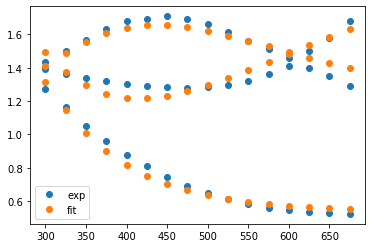

Fitted parameters:
[ 0.10878692  0.94672154  4.19968113  2.15396276  0.96713456 -1.53236046]
Uncertainties:
[0.00284961 0.02117339 0.22267411 0.04687917 0.03809707 0.20537901]
Covariance matrix:
             Eg300       Eac  e_m_elec  e_m_hole     kl300    kl_exp
Eg300     0.000008  0.000023 -0.000397 -0.000024  0.000012 -0.000002
Eac       0.000023  0.000448 -0.002863 -0.000898 -0.000115  0.002330
e_m_elec -0.000397 -0.002863  0.049584  0.005602 -0.001291  0.009343
e_m_hole -0.000024 -0.000898  0.005602  0.002198  0.000400 -0.004702
kl300     0.000012 -0.000115 -0.001291  0.000400  0.001451 -0.004924
kl_exp   -0.000002  0.002330  0.009343 -0.004702 -0.004924  0.042181
R_squared: 0.9835323154740363


In [18]:
def fit_function(x, b, c, d, e, h, i, properties = 'fit'):
    argument_dict = {'tot_carr_conc':     -4.9*1.0E19,
                     'Eg300'        :     b,
                     'Eac'          :     c,
                     'eff_mass_elec':     d, #1.06,  2.16
                     'eff_mass_hole':     e, #1.06, 
                     'density'      :     7700,
                     'sound_speed'  :     1850,
                     'kl300'        :     h,
                     'kl_exp'       :     i,
                     'Eg_lin'       :     -9.5
                    }
    
    x = x[:int(len(x)/3)]
    sample_test = Sample('test_name', x, argument_dict)
    
    if properties == 'fit':
        res = sample_test.points.T.ravel()
    else:
        res = sample_test.calculate_all()
    return res

initialParameters = np.array([0.1, 1.1369, 2.116, 1.688, 1.05, -0.4])

bounds = ([0, 0, 0, 0, 0, -5],[1.5, 50, 10, 10, 3, 0])

print('Fitting started...')
fittedParameters, pcov = curve_fit(fit_function, ComboX, ComboY, initialParameters, bounds = bounds)
perr = np.sqrt(np.diag(pcov))
print('Fitting finished...')

#fittedParameters = (15.0, 2.0, 2.0, 1.0, -1.0, -9.5)

ResultY = fit_function(ComboX, *fittedParameters)
plt.plot(ComboX[:], ComboY[:], 'o', label = 'exp')
plt.plot(ComboX[:], ResultY[:], 'o', label = 'fit')
plt.legend()
plt.show()

print('Fitted parameters:')
print(fittedParameters)
print('Uncertainties:')
print(perr)
print('Covariance matrix:')
names = ['Eg300', 'Eac', 'e_m_elec', 'e_m_hole', 'kl300', 'kl_exp']
print(pd.DataFrame(pcov, index = names, columns = names))

correlation_matrix = np.corrcoef(ComboY, ResultY)
correlation_xy = correlation_matrix[0,1]
r_squared = correlation_xy**2
print('R_squared: {}'.format(r_squared))

data = pd.DataFrame(fit_function(ComboX, *fittedParameters, properties = "All"), 
                    columns = ['Temperature', 'Red_chem_pot', 'electron_conc', 'hole_conc', 'carrier_diff',
                    'electron_sigma', 'hole_sigma', 'total_sigma', 'electron_Seebeck', 'hole_Seebeck', 'total_Seebeck', 'bipolar_therm_cond',
                    'electron_therm_cond', 'hole_therm_cond', 'carrier_therm_cond', 'latt_therm_cond', 'total_therm_cond'])

name = 'res_'+family+'_'+sample+'.csv'
data.to_csv(name)

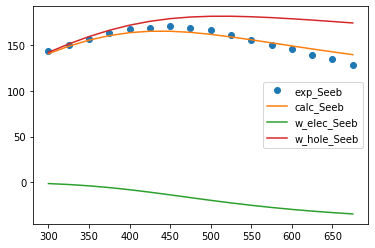

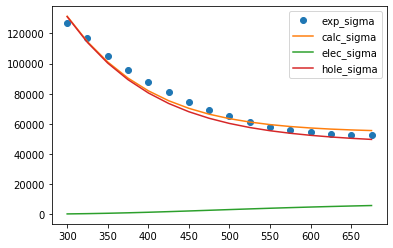

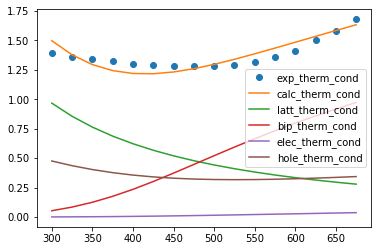

In [19]:
fig_data = pd.DataFrame(data['Temperature'])
fig_data['exp_Seeb'] = df['Seeb']
fig_data['calc_Seeb'] = data['total_Seebeck']*1.0E6
fig_data['w_elec_Seeb'] = data['electron_Seebeck']*1.0E6 * data['electron_sigma'] / data['total_sigma']
fig_data['w_hole_Seeb'] = data['hole_Seebeck']*1.0E6 * data['hole_sigma'] / data['total_sigma']

fig_data['exp_sigma'] = df['sigma']*100
fig_data['calc_sigma'] = data['total_sigma']
fig_data['elec_sigma'] = data['electron_sigma']
fig_data['hole_sigma'] = data['hole_sigma']

fig_data['exp_therm_cond'] = df['kappa']
fig_data['calc_therm_cond'] = data['total_therm_cond']
fig_data['latt_therm_cond'] = data['latt_therm_cond']
fig_data['bip_therm_cond'] = data['bipolar_therm_cond']
fig_data['elec_therm_cond'] = data['electron_therm_cond']
fig_data['hole_therm_cond'] = data['hole_therm_cond']

def draw(value_symbol_pair_list):
    for value, symbol in value_symbol_pair_list:
        plt.plot(fig_data['Temperature'], fig_data[value], symbol, label = value)
    plt.legend()
    plt.show()

Seebeck = [('exp_Seeb', 'o'), ('calc_Seeb', '-'), ('w_elec_Seeb', '-'), ('w_hole_Seeb','-')]
sigma = [('exp_sigma', 'o'), ('calc_sigma', '-'), ('elec_sigma', '-'), ('hole_sigma','-')]
kappa = [('exp_therm_cond', 'o'), ('calc_therm_cond', '-'), ('latt_therm_cond', '-'), ('bip_therm_cond','-'), ('elec_therm_cond','-'), ('hole_therm_cond','-')]

draw(Seebeck)
draw(sigma)
draw(kappa)

In [10]:
def fit_function_set(T_list, a, b, properties = 'All'):
    argument_dict = {'tot_carr_conc':     a,
                     'Eg300'        :     b,
                     'Eac'          :     1.16,#1.25,
                     'eff_mass_elec':     2.15,#2.40, 
                     'eff_mass_hole':     2.50,#1.0, 
                     'density'      :     7700,
                     'sound_speed'  :     1850,
                     'kl300'        :     0.5,#0.5,
                     'kl_exp'       :     -0.95,#-0.4,
                     'Eg_lin'       :     -9.5
                    }
    
    #x = x[:int(len(x)/3)]
    sample_test = Sample('test_name', T_list, argument_dict)
    
    if properties == 'fit':
        res = sample_test.points.T.ravel()
    else:
        res = sample_test.calculate_all()
    return res

columns_appended = ['Temperature', 'Red_chem_pot', 'electron_conc', 'hole_conc', 'carrier_diff',\
                    'electron_sigma', 'hole_sigma', 'total_sigma', 'electron_Seebeck', 'hole_Seebeck', 'total_Seebeck', 'bipolar_therm_cond',\
                    'electron_therm_cond', 'hole_therm_cond', 'carrier_therm_cond', 'latt_therm_cond', 'total_therm_cond', 'carr_conc/1E19', 'Eg300/eV']

def fit_function_wrap(T, a, b):
    T_list = [T]
    res = fit_function_set(T_list, a, b, properties = 'All')
    
    res = np.append(res, a)
    res = np.append(res, b)

    return res

def calculate_map():
    #concentrations_list = np.logspace(0, 2, 16)*5.0E18
    concentrations_list = np.logspace(0, 3, 16)*5.0E17
    print(concentrations_list)
    #bandgap_list = np.linspace(0.1, 0.4, 16)
    bandgap_list = np.linspace(0.1, 1.0, 20)
    print(bandgap_list)
    T_list = np.linspace(300, 675, 16)
    print(T_list)
    
    #concentrations_list = [5, 15]
    #bandgap_list = [0.2, 0.21]
    #T_list = [300, 500]
    
    result = np.empty(shape = 19)
    
    for a in concentrations_list:
        print("Concentration: {} cm**-3".format(a))
        for b in bandgap_list:
            for T in T_list:
                result = np.vstack((result, np.array(fit_function_wrap(T, a, b))))
    
    return pd.DataFrame(result[1:], columns = columns_appended)

test_dataframe = calculate_map()
test_dataframe.to_csv('res_map_extended_2.csv')
print(test_dataframe.head())
    



[5.00000000e+17 7.92446596e+17 1.25594322e+18 1.99053585e+18
 3.15478672e+18 5.00000000e+18 7.92446596e+18 1.25594322e+19
 1.99053585e+19 3.15478672e+19 5.00000000e+19 7.92446596e+19
 1.25594322e+20 1.99053585e+20 3.15478672e+20 5.00000000e+20]
[0.1        0.14736842 0.19473684 0.24210526 0.28947368 0.33684211
 0.38421053 0.43157895 0.47894737 0.52631579 0.57368421 0.62105263
 0.66842105 0.71578947 0.76315789 0.81052632 0.85789474 0.90526316
 0.95263158 1.        ]
[300. 325. 350. 375. 400. 425. 450. 475. 500. 525. 550. 575. 600. 625.
 650. 675.]
Concentration: 5e+17 cm**-3


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "C:\Users\rafal\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3267, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-10-2a623c67e1f5>", line 60, in <module>
    test_dataframe = calculate_map()
  File "<ipython-input-10-2a623c67e1f5>", line 56, in calculate_map
    result = np.vstack((result, np.array(fit_function_wrap(T, a, b))))
  File "<ipython-input-10-2a623c67e1f5>", line 29, in fit_function_wrap
    res = fit_function_set(T_list, a, b, properties = 'All')
  File "<ipython-input-10-2a623c67e1f5>", line 20, in fit_function_set
    res = sample_test.calculate_all()
  File "<ipython-input-3-c4a4424c10c2>", line 35, in calculate_all
    return np.array([Point_SKB(self.tot_carr_conc, T, self.Eg300, self.Eac, self.eff_mass_elec, self.eff_mass_hole, self.density, self.sound_speed, self.kl300, self.kl_exp, self.Eg_lin).report(calculate = 'All') for T in self.T_list])
  File "<ipython-in

KeyboardInterrupt: 

In [13]:
#Use only for exporting specific portions of the table
#Contains delierate error

df = pd.read_csv("res_map.csv")

df['PF'] = (df['total_Seebeck']**2) * df['total_sigma']
df['ZT'] = df['PF'] * df['Temperature'] / df['total_therm_cond']
df['compatibility_factor'] = (((df['ZT'] + 1)**(1/2)) - 1) / (abs(df['total_Seebeck'])*df['Temperature'])

#print(df.head())
#print(df.shape)
#print(df.columns)

temp_val = #0.24
temp_df = df[df['Eg300/eV']==temp_val]
temp_df.to_csv('Eg'+str(temp_val)+'.csv')


(4096, 20)
Index(['Unnamed: 0', 'Temperature', 'Red_chem_pot', 'electron_conc',
       'hole_conc', 'carrier_diff', 'electron_sigma', 'hole_sigma',
       'total_sigma', 'electron_Seebeck', 'hole_Seebeck', 'total_Seebeck',
       'bipolar_therm_cond', 'electron_therm_cond', 'hole_therm_cond',
       'carrier_therm_cond', 'latt_therm_cond', 'total_therm_cond',
       'carr_conc/1E19', 'Eg300/eV'],
      dtype='object')
   Unnamed: 0  Temperature  Red_chem_pot  electron_conc     hole_conc  \
0           0        300.0     -0.706887   2.449972e+19  2.096585e+17   
1           1        325.0     -0.725822   2.810695e+19  3.348501e+17   
2           2        350.0     -0.741027   3.200429e+19  5.051162e+17   
3           3        375.0     -0.753432   3.619040e+19  7.275145e+17   
4           4        400.0     -0.763702   4.066375e+19  1.008691e+18   

   carrier_diff  electron_sigma   hole_sigma   total_sigma  electron_Seebeck  \
0      3.858013    32119.900936  2859.011298  34978.912234 

In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import integrate

df = pd.read_csv("res_map.csv")
print(df.shape)
print(df.columns)
df['PF'] = (df['total_Seebeck']**2) * df['total_sigma']
df['ZT'] = df['PF'] * df['Temperature'] / df['total_therm_cond']
df['compatibility_factor'] = (((df['ZT'] + 1)**(1/2)) - 1) / (abs(df['total_Seebeck'])*df['Temperature'])
print(df.head())

def calc_ZTave(Temps, ZT):
    deltaT = Temps.iloc[-1] - Temps.iloc[0]   
    trap_ZTave = np.trapz(ZT, Temps)/deltaT
    return trap_ZTave

def wrap_calc_ZTave(grouping):
    (group_label, df) = grouping
    ZTave = calc_ZTave(df['Temperature'], df['ZT'])
    return np.array([*group_label, ZTave])

def calc_self_compatibility(Temps, Comp_factor):
    deltaT = Temps.iloc[-1] - Temps.iloc[0] 
    abs_dsdt = np.abs(np.gradient(Comp_factor, Temps))
    return np.trapz(abs_dsdt, Temps)/deltaT

def wrap_calc_self_compatibility(grouping):
    (group_label, df) = grouping
    S = calc_self_compatibility(df['Temperature'], df['compatibility_factor'])
    return np.array([*group_label, S])

grouping = df.groupby(['carr_conc/1E19','Eg300/eV'])

ZTave_list = [wrap_calc_ZTave(i) for i in grouping]
df_ZTave = pd.DataFrame(data = ZTave_list, columns = ['carr_conc','Eg300','ZTave']).set_index(['carr_conc', 'Eg300'])
print(df_ZTave.head())
print(df_ZTave.shape)

S_list = [wrap_calc_self_compatibility(i) for i in grouping]
df_S = pd.DataFrame(data = S_list, columns = ['carr_conc','Eg300','S']).set_index(['carr_conc', 'Eg300'])
print(df_S.head())
print(df_S.shape)

ZTmax = grouping['ZT'].max()
df_ZTmax = ZTmax.to_frame(name = 'ZTmax')
print(df_ZTmax.head())
print(df_ZTmax.shape)

df_joined = df_ZTave.join([df_ZTmax, df_S], how = 'inner')
print(df_joined.head())
print(df_joined.shape)

df_joined = df_joined.reset_index()
df_joined.to_csv('ZT_S_map.csv')


(5120, 20)
Index(['Unnamed: 0', 'Temperature', 'Red_chem_pot', 'electron_conc',
       'hole_conc', 'carrier_diff', 'electron_sigma', 'hole_sigma',
       'total_sigma', 'electron_Seebeck', 'hole_Seebeck', 'total_Seebeck',
       'bipolar_therm_cond', 'electron_therm_cond', 'hole_therm_cond',
       'carrier_therm_cond', 'latt_therm_cond', 'total_therm_cond',
       'carr_conc/1E19', 'Eg300/eV'],
      dtype='object')
   Unnamed: 0  Temperature  Red_chem_pot  electron_conc     hole_conc  \
0           0        300.0     -2.310447   4.560447e+18  4.060447e+18   
1           1        325.0     -2.176518   6.057139e+18  5.557139e+18   
2           2        350.0     -2.058921   7.831272e+18  7.331272e+18   
3           3        375.0     -1.955281   9.893322e+18  9.393322e+18   
4           4        400.0     -1.863492   1.225198e+19  1.175198e+19   

   carrier_diff  electron_sigma   hole_sigma   total_sigma  electron_Seebeck  \
0 -6.144000e-15    10322.408833  6370.918317  16693.327150 

In [4]:
import scipy
scipy.__version__

'1.1.0'

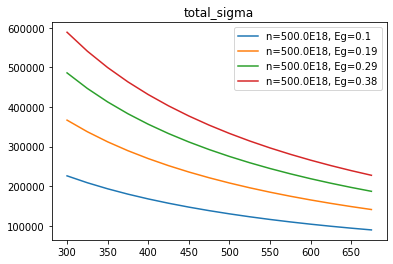

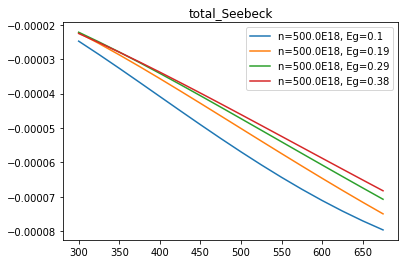

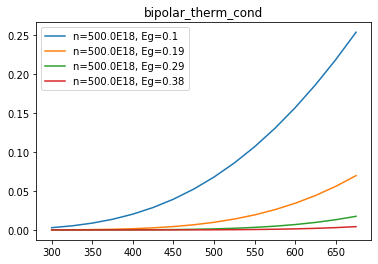

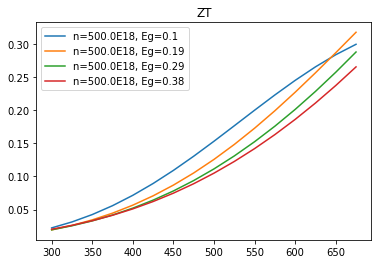

In [45]:
def add_ZT(df):
    df['PF'] = (df['total_Seebeck']**2) * df['total_sigma']
    df['ZT'] = df['PF'] * df['Temperature'] / df['total_therm_cond']
    df['compatibility_factor'] = (((df['ZT'] + 1)**(1/2)) - 1) / (abs(df['total_Seebeck'])*df['Temperature'])
    return df

def plot_thermoelectric(df, n_Eg_list, param_list = ['total_Seebeck', 'total_sigma', 'total_therm_cond', 'ZT']):
    
    def my_plot(df, n_Eg_value_pair_list, col_name):
        for n_Eg_value_pair in n_Eg_value_pair_list:
            carrier_unique, Eg300_unique = n_Eg_value_pair
            
            carr_uniq_val = list(df['carr_conc/1E19'].unique())[carrier_unique]
            Eg_uniq_val = list(df['Eg300/eV'].unique())[Eg300_unique]

            new_df = df[(df['carr_conc/1E19']==carr_uniq_val)&(df['Eg300/eV']==Eg_uniq_val)]
            plt.plot(new_df['Temperature'], new_df[col_name], label = "n={}E18, Eg={}".format(round(carr_uniq_val/1.0E18, 2), round(Eg_uniq_val,2)))

        plt.title(col_name)
        plt.legend()
        plt.show()
        
    [my_plot(df, n_Eg_list, param) for param in param_list]


    
    
my_df = pd.read_csv('res_map.csv')
my_df = add_ZT(my_df)

val_1 = 15

n_Eg_list = [(val_1,0), (val_1, 2), (val_1, 4), (val_1,6)]

plot_thermoelectric(my_df, n_Eg_list, param_list = ['total_sigma', 'total_Seebeck', 'bipolar_therm_cond', 'ZT'])